# **ML Project : Machine Learning applied to pair trading strategy**

Notebook made by Sence Benoit and Valletoux Baptiste



---



# **1- Introduction**

**Objective of the Project**

The primary objective of this project is to implement a pairs trading strategy—a mean-reversion approach—on a pair of European banking stocks. The analysis will focus on assessing the impact of incorporating a machine learning methodology, specifically an artificial neural network (ANN), on the spread dynamics and overall performance of the pairs trading strategy. The machine learning model will leverage macroeconomic and financial features derived from monthly data published by the European Central Bank (ECB), such as key economic indicators and interest rates.

**Understanding the Strategy: Mean Reversion and Pairs Trading**

Mean reversion is a fundamental concept in quantitative trading, premised on the belief that asset prices and spreads tend to revert to their historical averages over time. This principle underpins several trading strategies that capitalize on deviations from equilibrium. Pairs trading is a specific application of this principle, involving the simultaneous long position in one asset and short position in another, chosen for their historically correlated price movements. The goal is to exploit temporary divergences in the spread between the two assets, under the assumption that the spread will revert to its mean.

In this project, the spread will be modeled and monitored dynamically. Trades will be executed when the spread deviates significantly from its expected range, and positions will be closed once mean reversion occurs.

**Enhancing the Strategy with Machine Learning**

To enhance the traditional pairs trading strategy, we will employ an artificial neural network (ANN), a type of machine learning algorithm inspired by the architecture of the human brain. ANNs are particularly adept at capturing complex, nonlinear relationships in data, making them suitable for financial applications. The ANN in this project will be trained on macroeconomic and financial features, such as those published monthly by the ECB, to better understand and predict the dynamics of the spread.




---



## **Libraries installation and importation**

* We import essential libraries for data manipulation (pandas, numpy), financial data retrieval (yfinance), statistical tests (statmodels) and ECB macroeconomic indicators (ecbdata). matplotlib is used for data visualization.




In [49]:
%pip install ecbdata
%pip install yfinance
%pip install statsmodels
%pip install numpy
%pip install scikit-learn
%pip install tensorflow
%pip install seaborn
%pip install jinja2

In [50]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from itertools import combinations
from ecbdata import ecbdata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense


# **2- Dataset overview**

## Dataset 1: UE Banks prices (Yahoo finance API: https://fr.finance.yahoo.com/):

* In this section, we retrieve historical **adjusted closing prices** for **15 major European banks** from Yahoo Finance. This dataset spans from **January 2014 to January 2024**. We perform data cleaning by removing any infinite values or missing data points to ensure a robust analysis free of computational errors.

[*********************100%***********************]  15 of 15 completed


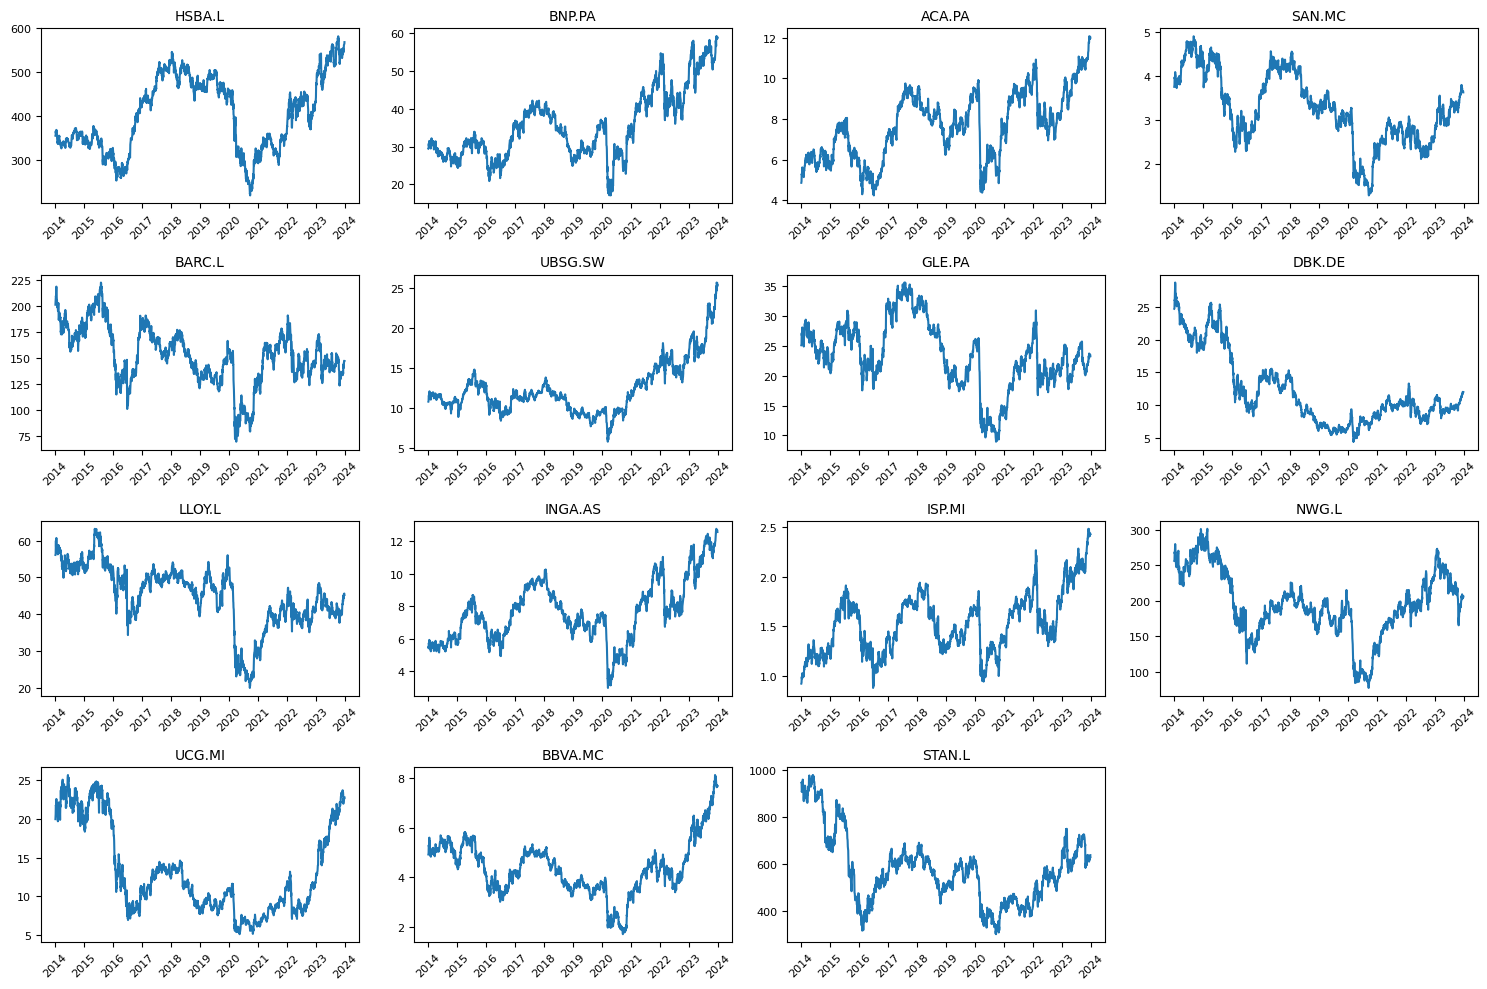

In [51]:
# UE Banks Tickers
tickers = [
    'HSBA.L',       # HSBC Holdings plc
    'BNP.PA',       # BNP Paribas SA
    'ACA.PA',       # Crédit Agricole Group
    'SAN.MC',       # Banco Santander SA
    'BARC.L',       # Barclays PLC
    'UBSG.SW',      # UBS Group AG
    'GLE.PA',       # Société Générale SA
    'DBK.DE',       # Deutsche Bank AG
    'LLOY.L',       # Lloyds Banking Group PLC
    'INGA.AS',      # ING Groep NV
    'ISP.MI',       # Intesa Sanpaolo SpA
    'NWG.L',        # NatWest Group PLC
    'UCG.MI',       # UniCredit SpA
    'BBVA.MC',      # Banco Bilbao Vizcaya Argentaria (BBVA)
    'STAN.L',       # Standard Chartered PLC
]

# Downloading Data from Yahoo Finance
data_banks = yf.download(tickers, start="2014-01-01", end="2024-01-01")['Adj Close']

# Data Cleaning: Removing Infinite Values and NaNs
data_banks = data_banks.replace([float('inf'), float('-inf')], None).dropna()

# Time series vizualisation
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
axes = axes.flatten()

# Plot each bank's adjusted closing price
for i, ticker in enumerate(tickers):
    if i < len(axes):
        axes[i].plot(data_banks.index, data_banks[ticker], label=ticker)
        axes[i].set_title(ticker, fontsize=10)
        axes[i].tick_params(axis='x', labelsize=8, rotation=45)
        axes[i].tick_params(axis='y', labelsize=8)

# Remove extra subplots if fewer than 16 tickers
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and display
plt.tight_layout()
plt.show()


## Dataset from ECB (ECB website: https://data.ecb.europa.eu/data/data-categories)

### We selected macroeconomic indicators to provide a relevant dataset for predicting spreads in the pair trading strategy applied to bank stocks. However, while these variables capture critical aspects of banks’ operations, it is essential to keep in mind their potential limitations and consider areas for improvement.

### Analysis of Macroeconomic Indicators:

1. **HICP (Harmonized Index of Consumer Prices) - Overall Index**  
   -Inflation is a key driver of central bank policies, directly influencing interest rates and, in turn, banks’ net interest margins. It serves as a broad measure of economic conditions affecting bank's profits.  

2. **Bank Business Volumes - Loans to Corporations (Floating Rate, < €0.25M, Short-Term)**  
   -Lending volumes are a direct proxy for banks’ credit activities, particularly in the small corporate segment. These loans are sensitive to monetary policy and economic conditions, making this variable highly relevant.  

3. **Bank Interest Rates - Overnight Deposits from Households**  
   -Household deposit rates reflect banks’ funding costs and their ability to attract stable retail deposits. Changes in these rates influence net interest margins, a critical profitability driver.  
   
4. **Bank Interest Rates - Overnight Deposits from Corporations**  
   -Corporate deposit rates provide insights into short-term liquidity trends and the health of corporate cash flows, both of which are crucial for banks.  

5. **Bank Business Volumes - Loans to Households for Consumption (1-5 Years Term)**  
   -Consumer lending is a major source of retail banking revenue. Trends in this data could reflect household confidence, credit demand, and broader economic conditions, all of which impact bank performance.  


In [52]:
#List of Tickers
data_tickers = [
   'ICP.M.U2.N.000000.4.ANR', #HICP - Overall index, Euro area (changing composition), Monthly
   'MIR.M.U2.B.A2A.D.B.2.2240.EUR.N', #Bank business volumes - loans to corporations of up to EUR 0.25M with a floating rate and an IRF period of up to three months (new business) - euro area, Euro area (changing composition), Monthly
   'MIR.M.U2.B.L21.A.R.A.2250.EUR.N', #Bank interest rates - overnight deposits from households - euro area, Euro area (changing composition), Monthly
   'MIR.M.U2.B.L21.A.R.A.2240.EUR.N', #Bank interest rates - overnight deposits from corporations - euro area, Euro area (changing composition), Monthly
   'MIR.M.U2.B.A2B.A.B.A.2250.EUR.N' #Bank business volumes - loans to households for consumption with an IRF period of over one & up to five years (new business) - euro area, Euro area (changing composition), Monthly
]


#Initialize a DataFrame for the Combination
combined_df = pd.DataFrame()

# Loop Through Tickers to Retrieve Data
for ticker in data_tickers:
    # Retrieve Data for the Ticker
    df = ecbdata.get_series(ticker, start='2014-01', end='2024-01')

    # Rename TIME_PERIOD to Date or Use Index if Necessary
    if 'TIME_PERIOD' in df.columns:
        df = df.rename(columns={'TIME_PERIOD': 'Date'})
    else:
        df['Date'] = df.index  #Use the Index as the Date Column if TIME_PERIOD Does Not Exist

    # Add Only the Date and OBS_VALUE Columns
    df = df[['Date', 'OBS_VALUE']].rename(columns={'OBS_VALUE': ticker})

    # Merge on the "Date" Column
    if combined_df.empty:
        combined_df = df
    else:
        combined_df = combined_df.merge(df, on='Date', how='outer')

# Sort by Date
combined_df_ecb = combined_df.sort_values(by='Date').reset_index(drop=True)

# Display the Final DataFrame
combined_df_ecb


,Date,ICP.M.U2.N.000000.4.ANR,MIR.M.U2.B.A2A.D.B.2.2240.EUR.N,MIR.M.U2.B.L21.A.R.A.2250.EUR.N,MIR.M.U2.B.L21.A.R.A.2240.EUR.N,MIR.M.U2.B.A2B.A.B.A.2250.EUR.N
0,2014-01,0.8,16901.29,0.26,0.33,14709.95
1,2014-02,0.7,15217.19,0.26,0.33,14450.08
2,2014-03,0.5,17302.99,0.26,0.35,16115.72
3,2014-04,0.7,17512.04,0.26,0.34,16598.42
4,2014-05,0.5,16723.19,0.26,0.34,15999.55
...,...,...,...,...,...,...
116,2023-09,4.3,23619.72,0.33,0.75,23529.46
117,2023-10,2.9,24394.89,0.35,0.80,25260.42
118,2023-11,2.4,24844.12,0.36,0.83,24548.01
119,2023-12,2.9,27187.93,0.37,0.84,20122.57




---



# **3- Analytics and learning strategies**

* We **compute spreads** for all unique pairs of bank stocks by subtracting adjusted closing prices. Each pair's spread is stored in a separate column of the resulting DataFrame, creating a comprehensive representation of potential pair relationships for further analysis.
* We chose to work on **log returns** rather than prices for the implementation of a pairs trading strategy because log returns provide stationarity and better statistical properties, facilitating the modeling and analysis of the relationship between the two assets.

In [53]:
# Initialize the spreads dictionary
spreads = {}
tickers = data_banks.columns

# Calculate spreads and log returns
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        pair_name = f"{tickers[i]}_{tickers[j]}"
        spread = data_banks[tickers[i]] - data_banks[tickers[j]]

        # Filter invalid values (avoid zeros and negatives for log calculation)
        valid_spread = spread[spread > 0]
        spread_log_return = np.log(valid_spread / valid_spread.shift(1)).dropna()

        spreads[pair_name] = spread_log_return

# Create the spreads DataFrame
spread_df = pd.DataFrame(spreads)


- We apply the **Augmented Dickey-Fuller (ADF) test** on each spread time series to assess its stationarity. A time series is considered stationary if its statistical properties, such as mean and variance, remain constant over time. Spreads with p-values below 0.05 are marked as stationary, indicating **mean-reverting behavior** suitable for pairs trading strategies.

- **Augmented Dickey-Fuller Test (ADF):**  
  The Augmented Dickey-Fuller test assesses whether a time series has a **unit root**, testing for non-stationarity. If the test statistic rejects the null hypothesis, the series is stationary. The ADF equation is:  

$$
\Delta y(t) = \lambda y(t-1) + \mu + \beta t + \alpha_1 \Delta y(t-1) + \dots + \alpha_k \Delta y(t-k) + \epsilon_t
$$  

If $\lambda = 0 \$ the series follows a random walk. Otherwise, the series exhibits **mean-reversion**.


In [54]:
adf_results = {}

for col in spread_df.columns:
    # Filter out NaN values and check if there are at least 2 data points for the ADF test
    data = spread_df[col].dropna()
    if len(data) > 1:  # ADF test requires at least 2 non-NaN observations
        result = adfuller(data)
        adf_results[col] = {
            "ADF Statistic": result[0],
            "p-value": result[1],
            "Critical Values": result[4],
            "Stationary": result[1] < 0.05  # True if p-value < 0.05
        }

# Create the ADF results DataFrame
adf_results_df = pd.DataFrame(adf_results).T


In [55]:
stationary_pairs = adf_results_df[adf_results_df["Stationary"]].index
print("Stationary Pairs:", stationary_pairs)

Stationary Pairs: Index(['ACA.PA_BBVA.MC', 'ACA.PA_DBK.DE', 'ACA.PA_INGA.AS', 'ACA.PA_ISP.MI',
       'ACA.PA_SAN.MC', 'ACA.PA_UBSG.SW', 'ACA.PA_UCG.MI', 'BARC.L_BBVA.MC',
       'BARC.L_BNP.PA', 'BARC.L_DBK.DE', 'BARC.L_GLE.PA', 'BARC.L_INGA.AS',
       'BARC.L_ISP.MI', 'BARC.L_LLOY.L', 'BARC.L_NWG.L', 'BARC.L_SAN.MC',
       'BARC.L_UBSG.SW', 'BARC.L_UCG.MI', 'BBVA.MC_ISP.MI', 'BBVA.MC_SAN.MC',
       'BNP.PA_DBK.DE', 'BNP.PA_GLE.PA', 'BNP.PA_INGA.AS', 'BNP.PA_ISP.MI',
       'BNP.PA_LLOY.L', 'BNP.PA_SAN.MC', 'BNP.PA_UBSG.SW', 'BNP.PA_UCG.MI',
       'DBK.DE_INGA.AS', 'DBK.DE_ISP.MI', 'DBK.DE_SAN.MC', 'DBK.DE_UBSG.SW',
       'DBK.DE_UCG.MI', 'GLE.PA_INGA.AS', 'GLE.PA_ISP.MI', 'GLE.PA_SAN.MC',
       'GLE.PA_UBSG.SW', 'GLE.PA_UCG.MI', 'HSBA.L_INGA.AS', 'HSBA.L_ISP.MI',
       'HSBA.L_LLOY.L', 'HSBA.L_NWG.L', 'HSBA.L_SAN.MC', 'HSBA.L_STAN.L',
       'HSBA.L_UBSG.SW', 'HSBA.L_UCG.MI', 'INGA.AS_ISP.MI', 'INGA.AS_SAN.MC',
       'INGA.AS_UCG.MI', 'LLOY.L_SAN.MC', 'LLOY.L_UBSG.SW', 'LLOY.


* Here we define functions to analyze pair properties:
1. Hurst Exponent

The **Hurst Exponent** measures the rate of diffusion in a time series to identify whether it is mean-reverting, trending, or purely random. The variance of the series is proportional to the time lag and grows as:

$$
\text{Var}(x(t)) = \langle |x(t + \tau) - x(t)|^2 \rangle \sim \tau^{2H}
$$  

Where \( H \) is the Hurst Exponent:  

- \( H $\approx$ 0 \): Strong **mean-reversion**.  
- \( H $\approx$ 0.5 \): Geometric **random walk**.  
- \( H $\approx$ 1 \): **Trend-following** behavior.  

This metric helps analyze the **persistence** or anti-persistence of a time series.

2. Half-Life of Mean-Reversion

The **Half-Life of Mean-Reversion** measures the time it takes for a time series to revert to its mean after a shock. It is derived from the **Ornstein-Uhlenbeck process**, where the expected value evolves as:  

$$
E(y(t)) = y_0 \exp(\lambda t) - \frac{\mu}{\lambda} \left( 1 - \exp(\lambda t) \right)
$$  

The **half-life** is inversely proportional to the absolute value of $\lambda$ and is given by:  

$$
\text{Half-life} = -\frac{\ln(2)}{\lambda}
$$  

A **larger** $|\lambda|$ implies faster mean reversion, while a smaller $|\lambda|$ indicates slower reversion.


The article "**Applying Hurst Exponent in Pair Trading Strategies**" written by Quynh Bui and Robert Ślepaczuk provided us a detailed framework for incorporating the Generalized Hurst Exponent (GHE) into pair trading strategies, demonstrating its effectiveness in identifying mean-reverting pairs.


In [56]:
# Function to Calculate the Hurst Exponent Using the R/S Method
def rescaled_range(series):
    N = len(series)
    mean_adj_series = series - np.mean(series)
    cumulative_series = np.cumsum(mean_adj_series)
    R = np.max(cumulative_series) - np.min(cumulative_series)
    S = np.std(series)
    return R / S if S != 0 else 0

In [57]:
def calculate_hurst(series, max_lag=20):
    lags = range(2, max_lag)
    rs = [rescaled_range(series[:lag]) for lag in lags]
    log_rs = np.log(rs)
    log_lags = np.log(lags)
    slope, _ = np.polyfit(log_lags, log_rs, 1)
    return slope

In [58]:
# Function to Calculate the Half-Life of Mean Reversion
def calculate_half_life(series):
    lagged_series = series.shift(1).dropna()
    delta = series[1:] - lagged_series
    beta = np.polyfit(lagged_series, delta, 1)[0]
    half_life = -np.log(2) / beta if beta != 0 else np.nan
    return half_life


In [59]:
# Calculations for Each Stationary Pair
results = []
for pair in stationary_pairs:
    series = spread_df[pair].dropna()
    hurst = calculate_hurst(series)
    half_life = calculate_half_life(series)
    results.append({"Pair": pair, "Hurst Exponent": hurst, "Half-Life": half_life})

results_df = pd.DataFrame(results)
results_df

,Pair,Hurst Exponent,Half-Life
0,ACA.PA_BBVA.MC,0.363031,0.488547
1,ACA.PA_DBK.DE,0.636322,0.581490
2,ACA.PA_INGA.AS,0.543609,0.573523
3,ACA.PA_ISP.MI,0.761158,0.713863
4,ACA.PA_SAN.MC,0.683825,0.700167
5,ACA.PA_UBSG.SW,0.316288,0.624307
6,ACA.PA_UCG.MI,0.638055,0.548638
7,BARC.L_BBVA.MC,0.914624,0.711105
8,BARC.L_BNP.PA,0.917842,0.706887
9,BARC.L_DBK.DE,0.910328,0.712699


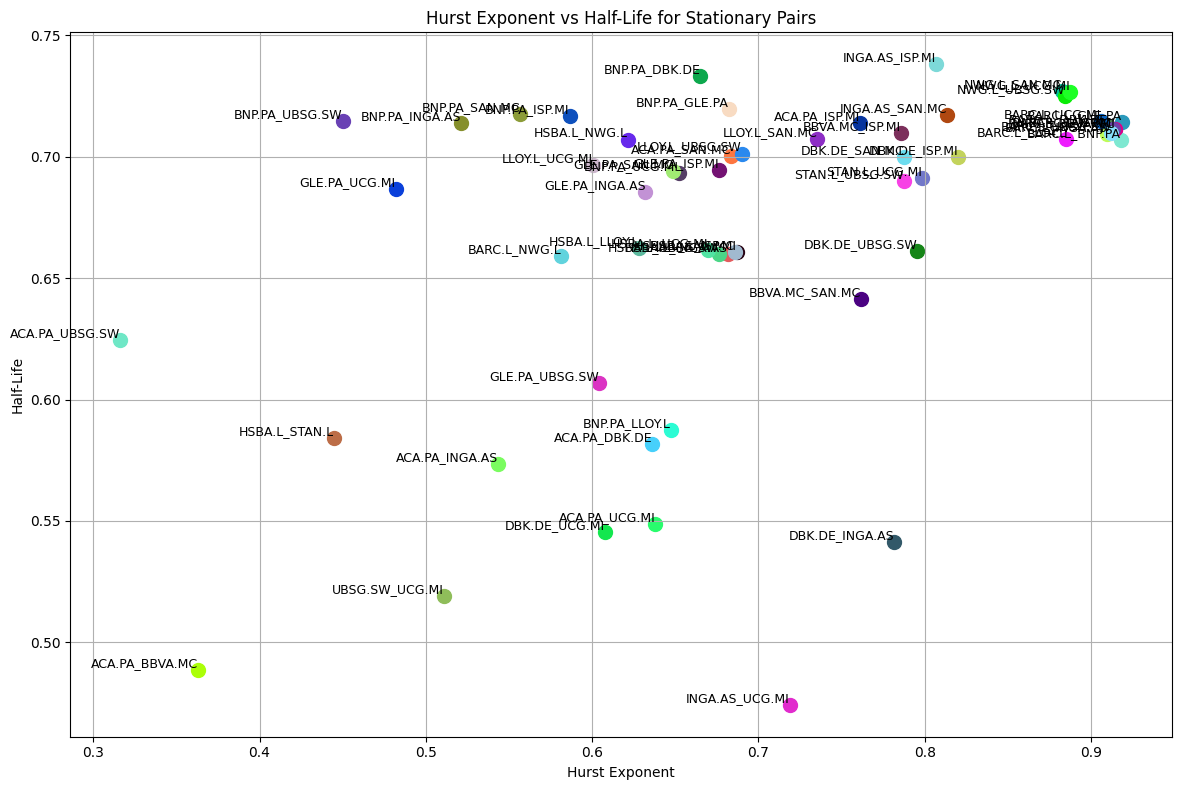

In [60]:
# Visualization of pairs
plt.figure(figsize=(12, 8))

for i, row in results_df.iterrows():
    plt.scatter(row["Hurst Exponent"], row["Half-Life"], s=100, color=np.random.rand(3,))
    plt.text(row["Hurst Exponent"], row["Half-Life"], row["Pair"], fontsize=9, ha='right', va='bottom')

plt.xlabel("Hurst Exponent")
plt.ylabel("Half-Life")
plt.title("Hurst Exponent vs Half-Life for Stationary Pairs")
plt.grid(True)
plt.tight_layout()

plt.show()

* Here we calculate spreads for stationary pairs and apply the **Engle-Granger test** to evaluate whether these pairs are cointegrated by checking the stationarity of their regression residuals.
* Cointegration

**Cointegration**, first introduced by Engle and Granger, refers to a situation where a linear combination of two or more **non-stationary time series** becomes **stationary**. Mathematically, for two I(1) series $y_t$ and $x_t$, there exist coefficients $\mu$ and $\beta$ such that:  

$$
y_t - \beta x_t = u_t + \mu,
$$  

where $u_t$ is a **stationary residual** series. This property is particularly valuable in finance, as it allows creating stationary combinations of otherwise non-stationary series, which is essential for strategies like **Pairs Trading**.

* **Engle-Granger Two-Step Method**  

1. **Check for unit roots** in both $y_t$ and $x_t$ using the **ADF test**. If both series are I(1), continue to step 2.  
2. **Perform a linear regression** of $y_t$ on $x_t$ following the equation above, using **Ordinary Least Squares (OLS)**, and record the residuals $\hat{u}_t$.  
3. **Test the residuals** $ \hat{u}_t$ for a unit root using the  **ADF test** (or a similar test).  
4. If the null hypothesis of a unit root in the residuals is **rejected**, the residual series is stationary, indicating that the two variables are **cointegrated**.  

The Engle-Granger method identifies stable, long-term relationships between time series. However, a known limitation is that the results can vary depending on the choice of the **dependent variable**. For multivariate cases, the **Johansen test** is typically a better alternative.


In [61]:
# Function to Recalculate Spreads
def calculate_spreads(data_banks, stationary_pairs):
    spreads = {}
    for pair in stationary_pairs:
        stock_1, stock_2 = pair.split('_')
        if stock_1 in data_banks.columns and stock_2 in data_banks.columns:
            spreads[pair] = data_banks[stock_1] - data_banks[stock_2]
    return pd.DataFrame(spreads)

# Function to Perform the Engle-Granger Test
def engle_granger_test(series_x, series_y):
    regression = sm.OLS(series_y, sm.add_constant(series_x)).fit()
    residuals = regression.resid
    adf_result = adfuller(residuals)
    p_value = adf_result[1]
    return {
        "ADF Statistic": adf_result[0],
        "p-value": p_value,
        "Critical Values": adf_result[4],
        "Cointegrated": p_value < 0.05
    }

# Recalculate Spreads from data_banks
spread_df = calculate_spreads(data_banks, stationary_pairs)

# Apply the Engle-Granger Test on Stationary Pairs
cointegration_results = []
for pair in stationary_pairs:
    if pair in spread_df.columns:
        series = spread_df[pair].dropna()
        valid_series = series[series > 0]  # Filter out non-positive values
        if valid_series.shape[0] > 2:  # Ensure sufficient data before log returns
            # Calculate Log Returns
            spread = np.log(valid_series / valid_series.shift(1)).dropna()
            if spread.shape[0] > 5:  # Check again after log returns for a larger sample
                aligned_series = pd.concat([spread.shift(1), spread], axis=1).dropna()
                if aligned_series.shape[0] > 5:  # Final check on aligned series size
                    series_x = aligned_series.iloc[:, 0]
                    series_y = aligned_series.iloc[:, 1]
                    # Perform the Engle-Granger Test
                    result = engle_granger_test(series_x, series_y)
                    cointegration_results.append({
                        "Pair": pair,
                        "ADF Statistic": result["ADF Statistic"],
                        "p-value": result["p-value"],
                        "Cointegrated": result["Cointegrated"]
                    })

# Compile Results
cointegration_results_df = pd.DataFrame(cointegration_results)
print(cointegration_results_df)


              Pair  ADF Statistic       p-value  Cointegrated
0   ACA.PA_BBVA.MC     -11.819337  8.487804e-22          True
1    ACA.PA_DBK.DE      -5.088780  1.476586e-05          True
2   ACA.PA_INGA.AS     -13.040537  2.246011e-24          True
3    ACA.PA_ISP.MI     -13.951089  4.700665e-26          True
4    ACA.PA_SAN.MC     -13.642058  1.645956e-25          True
5   ACA.PA_UBSG.SW      -3.431635  9.926565e-03          True
6    ACA.PA_UCG.MI      -4.869432  3.998085e-05          True
7   BARC.L_BBVA.MC     -13.542053  2.502235e-25          True
8    BARC.L_BNP.PA     -13.710179  1.241960e-25          True
9    BARC.L_DBK.DE     -13.475749  3.314828e-25          True
10   BARC.L_GLE.PA     -13.436081  3.927387e-25          True
11  BARC.L_INGA.AS     -13.586719  2.073657e-25          True
12   BARC.L_ISP.MI     -13.562743  2.293323e-25          True
13   BARC.L_LLOY.L     -13.346012  5.792985e-25          True
14    BARC.L_NWG.L      -7.683080  1.486047e-11          True
15   BAR

* After identifying stationary pairs, we select the **most cointegrated pair** based on the lowest p-value from the ADF test. This pair represents the strongest mean-reverting relationship, making it an ideal candidate for implementing a pair trading strategy.

In [62]:
# Filter Only Cointegrated Pairs
cointegrated_pairs = cointegration_results_df[cointegration_results_df["Cointegrated"]]

if not cointegrated_pairs.empty:
    # Find the Pair with the Smallest p-value
    most_cointegrated_pair = cointegrated_pairs.loc[cointegrated_pairs["p-value"].idxmin()]
    print("Most cointegrated is :")
    print(most_cointegrated_pair)
else:
    print("No pair found.")


Most cointegrated is :
Pair             BBVA.MC_ISP.MI
ADF Statistic        -30.695728
p-value                     0.0
Cointegrated               True
Name: 18, dtype: object


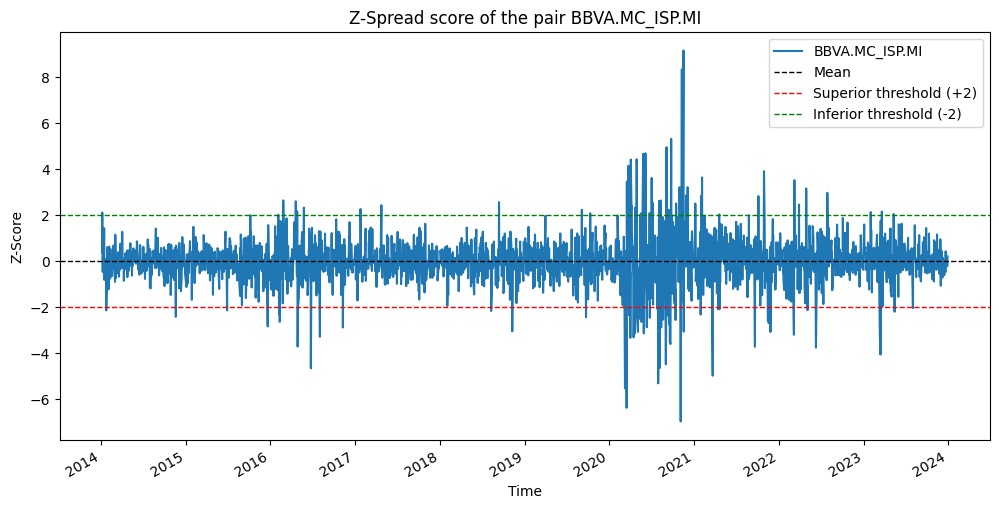

Date
2014-01-06    0.365056
2014-01-07    2.101876
2014-01-08    0.123685
2014-01-09   -0.476338
2014-01-10    0.201074
                ...   
2023-12-21    0.421310
2023-12-22   -0.069431
2023-12-27   -0.036568
2023-12-28   -0.227715
2023-12-29    0.200035
Name: BBVA.MC_ISP.MI, Length: 2462, dtype: float64


In [63]:
# Calculate the Z-Spread Score for the Most Cointegrated Pair
if most_cointegrated_pair is not None:
    import matplotlib.pyplot as plt

    pair_name = most_cointegrated_pair["Pair"]  # Retrieve the Name of the Pair
    if pair_name in spread_df.columns:
        spread = spread_df[pair_name].dropna()  # Extract the Spread without NaNs

        # Calculate Log Returns
        spread = np.log(spread / spread.shift(1)).dropna()

        # Calculate the Mean and Standard Deviation of the Spread
        mean_spread = spread.mean()
        std_spread = spread.std()

        # Calculate the Z-Spread Score
        z_score = (spread - mean_spread) / std_spread

        # Graph Z-Spread Score
        plt.figure(figsize=(12, 6))
        z_score.plot(title=f"Z-Spread score of the pair {pair_name}", ylabel="Z-Score", xlabel="Time")

        long_threshold = - 2
        short_threshold = 2
        exit_threshold = mean_spread

        plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label="Mean")
        plt.axhline(y=long_threshold, color='red', linestyle='--', linewidth=1, label="Superior threshold (+2)")
        plt.axhline(y=short_threshold, color='green', linestyle='--', linewidth=1, label="Inferior threshold (-2)")
        plt.legend()
        plt.show()
    else:
        print(f"The spread of the pair {pair_name} is not accessible.")
else:
    print("No pairs are cointegrated.")

print(z_score)

# **Pair trading strategy execution**

## Standard Pair Trading strategy execution

The goal of this section is to implement a pairs trading strategy by generating **trading signals** based on the **spread's deviation from its historical mean**. We define entry and exit rules using statistical thresholds derived from the spread’s historical mean and standard deviation.

The trading strategy exploits the mean-reversion behavior of a cointegrated spread by generating trading signals based on deviations from its historical mean. We calculate key thresholds:

- **Lower Entry (`alpha_L`)**: Two standard deviations below the mean, triggering a long position.
- **Upper Entry (`alpha_S`)**: Two standard deviations above the mean, triggering a short position.
- **Exit Threshold (`alpha_exit`)**: The mean itself, used to close positions.

The simulation tracks:

- **Position (1, -1, 0)**: Current trading stance.
- **PnL History**: Cumulative profit over time.
- **Trading Signals**: Logs of entry/exit events.

We enter a long position if the spread falls below `alpha_L` or a short position if it rises above `alpha_S`. Positions are closed when the spread reverts to the mean. This market-neutral strategy focuses solely on the assets’ relative performance, assuming price deviations are temporary and will correct over time.

Final Pnl : 10.679050418097749
Trading signal generated : 172


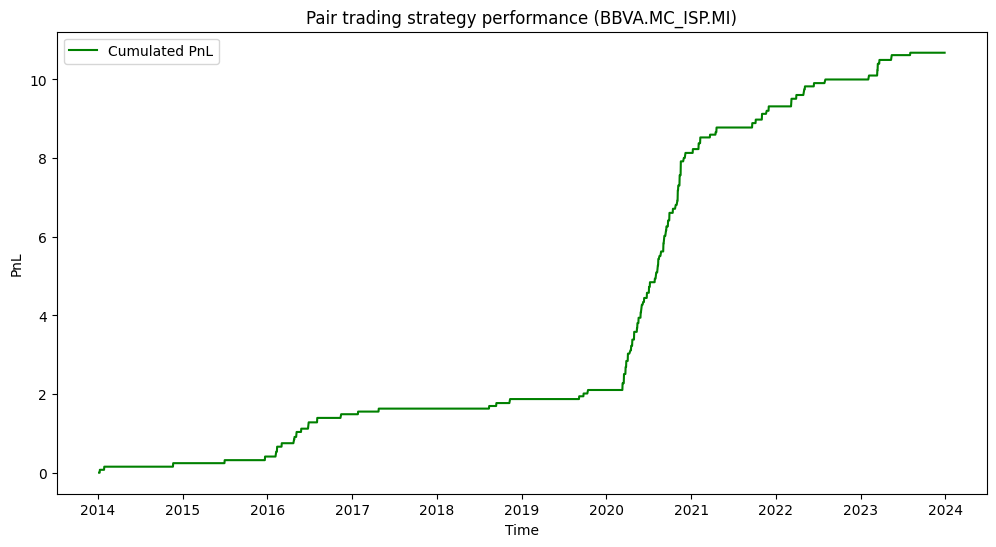

          Date      Signal
0   2014-01-07       Short
1   2014-01-09  Exit Short
2   2014-01-24        Long
3   2014-01-28   Exit Long
4   2014-11-20        Long
..         ...         ...
167 2023-03-23  Exit Short
168 2023-05-11       Short
169 2023-05-15  Exit Short
170 2023-08-02        Long
171 2023-08-03   Exit Long

[172 rows x 2 columns]


In [64]:
if most_cointegrated_pair is not None:
    pair_name = most_cointegrated_pair["Pair"]

    if pair_name in spread_df.columns:
        spread = spread_df[pair_name].dropna()

        # Log Returns Calculation
        spread = np.log(spread / spread.shift(1)).dropna()

        # Calculate the Mean and Standard Deviation of the Spread
        mean_spread = spread.mean()
        std_spread = spread.std()

        # Define the Thresholds
        alpha_L = mean_spread - 2*std_spread
        alpha_S = mean_spread + 2*std_spread
        alpha_exit = mean_spread

        # Initialization of Variables for the Strategy
        position = 0  # 0 = no position, 1 = long, -1 = short
        pnl = 0  # Cumulative Profit/Loss
        pnl_history = []  # PnL History
        signals = []  # Signal History

        # Daily Simulation
        for i in range(len(spread)):
            current_spread = spread.iloc[i]

            if position == 0:  # No position
                if current_spread < alpha_L:
                    position = 1  # Take a Long Position
                    entry_price = current_spread
                    signals.append((spread.index[i], "Long"))
                elif current_spread > alpha_S:
                    position = -1  # Take a short Position
                    entry_price = current_spread
                    signals.append((spread.index[i], "Short"))
            elif position == 1:  # Long position
                if current_spread >= alpha_exit:
                    pnl += current_spread - entry_price  # Pnl computation
                    position = 0  # Exit position
                    signals.append((spread.index[i], "Exit Long"))
            elif position == -1:  # Short position
                if current_spread <= alpha_exit:
                    pnl += entry_price - current_spread  # Pnl computation
                    position = 0  # Exit position
                    signals.append((spread.index[i], "Exit Short"))

            # Record the Cumulative PnL
            pnl_history.append(pnl)


        # Daily Returns
        daily_returns = np.diff(pnl_history) / 1  # Divisé par investissement initial

        # APR
        apr = ((np.sum(daily_returns)) * (252 / len(spread)))*100

        # Sharpe Ratio
        sharpe_ratio = (np.mean(daily_returns) - 0.03 / 100) / np.std(daily_returns) * np.sqrt(252)

        # Maximum Drawdown
        pnl_array = np.array(pnl_history)
        cumulative_max = np.maximum.accumulate(pnl_array)
        cumulative_max[cumulative_max == 0] = np.nan  # Éviter la division par zéro
        drawdowns = (cumulative_max - pnl_array) / cumulative_max
        max_drawdown = np.nanmax(drawdowns)

        # Strategy Results
        print(f"Final Pnl : {pnl}")
        print(f"Trading signal generated : {len(signals)}")

        # PnL Trading Signals

        plt.figure(figsize=(12, 6))
        plt.plot(spread.index, pnl_history, label="Cumulated PnL", color="green")
        plt.title(f"Pair trading strategy performance ({pair_name})")
        plt.xlabel("Time")
        plt.ylabel("PnL")
        plt.legend()
        plt.show()

        # Trading Signals
        signals_df = pd.DataFrame(signals, columns=["Date", "Signal"])
        print(signals_df)
    else:
        print(f"Pair spread {pair_name} is not available in spread_df.")
else:
    print("Zero pair cointegrated.")


We evaluate the performance of our trading strategy using key financial metrics:

- **Annualized Return (APR):** The annualized profitability of the strategy.
- **Sharpe Ratio:** Measures risk-adjusted returns relative to portfolio volatility.
- **Maximum Drawdown:** The largest observed loss from peak to trough during the trading period.

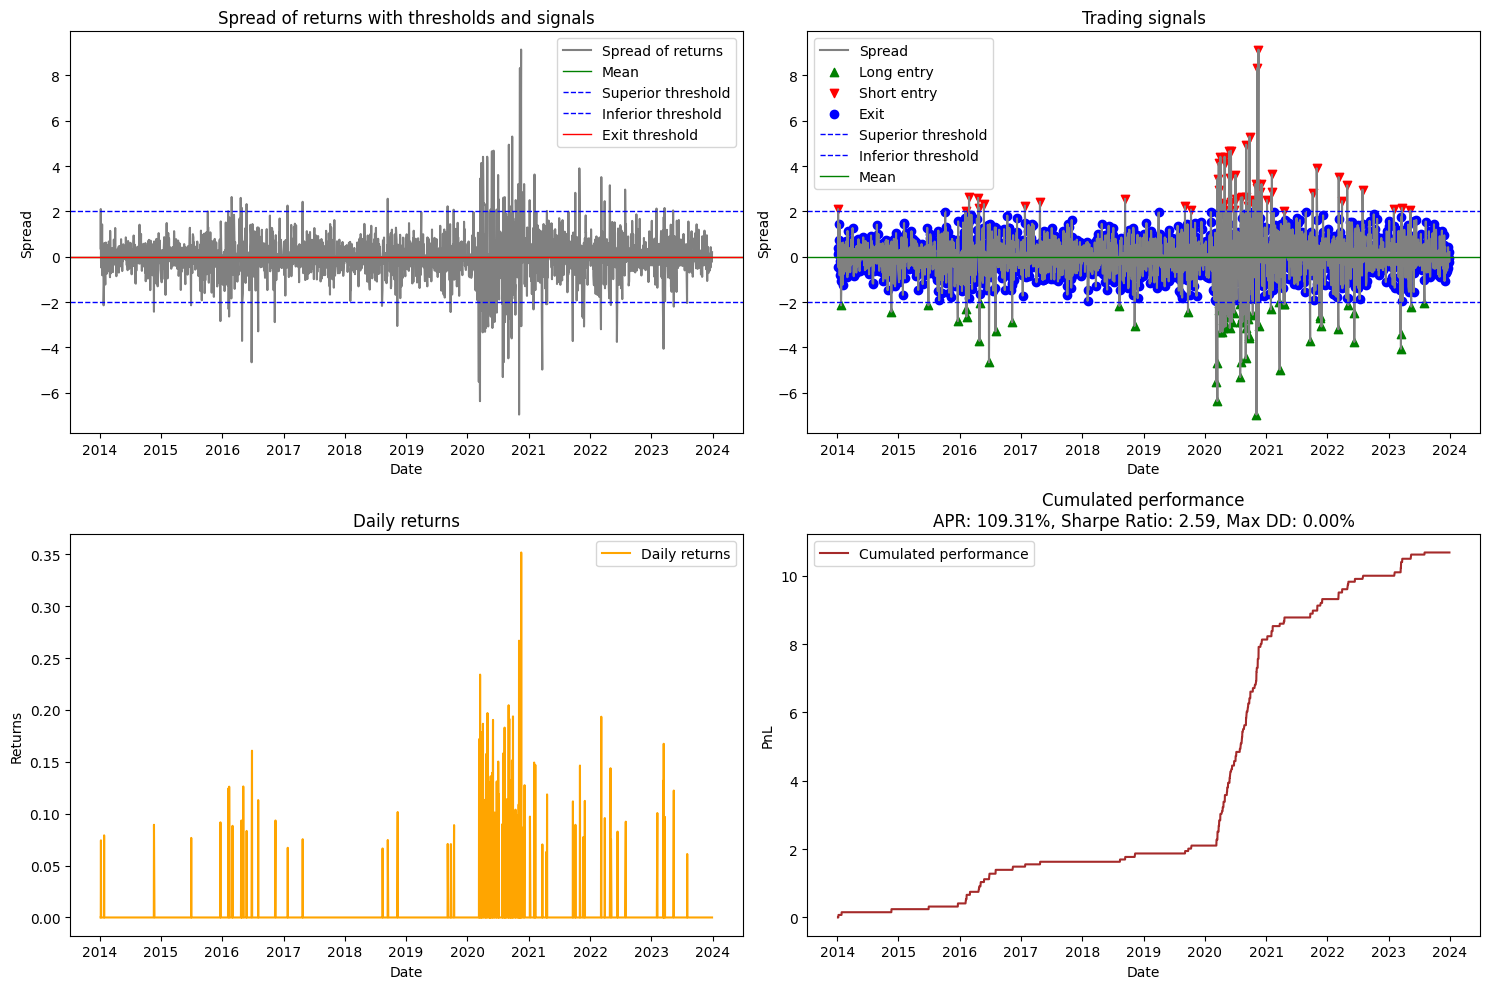

In [65]:
# Set the Thresholds for the Chart
spread = (spread - mean_spread) / std_spread
mean_spread = spread.mean()
std_spread = spread.std()
upper_threshold = mean_spread - 2*std_spread
lower_threshold = mean_spread + 2*std_spread
exit_threshold = mean_spread

# Creation of the Figure with Multiple Subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Chart 1: Spread with Thresholds and Signals
axs[0, 0].plot(spread.index, spread, label="Spread of returns", color="gray")
axs[0, 0].axhline(mean_spread, color="green", linestyle="-", linewidth=1, label="Mean")
axs[0, 0].axhline(upper_threshold, color="blue", linestyle="--", linewidth=1, label="Superior threshold")
axs[0, 0].axhline(lower_threshold, color="blue", linestyle="--", linewidth=1, label="Inferior threshold")
axs[0, 0].axhline(exit_threshold, color="red", linestyle="-", linewidth=1, label="Exit threshold")
axs[0, 0].legend()
axs[0, 0].set_title("Spread of returns with thresholds and signals")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Spread")

# Chart 2: Trading signals
long_signals = spread < upper_threshold
short_signals = spread > lower_threshold
exit_signals = (spread >= upper_threshold) & (spread <= lower_threshold)

axs[0, 1].plot(spread.index, spread, label="Spread", color="gray")
axs[0, 1].scatter(spread.index[long_signals], spread[long_signals], color="green", label="Long entry", marker="^")
axs[0, 1].scatter(spread.index[short_signals], spread[short_signals], color="red", label="Short entry", marker="v")
axs[0, 1].scatter(spread.index[exit_signals], spread[exit_signals], color="blue", label="Exit", marker="o")
axs[0, 1].axhline(upper_threshold, color="blue", linestyle="--", linewidth=1, label="Superior threshold")
axs[0, 1].axhline(lower_threshold, color="blue", linestyle="--", linewidth=1, label="Inferior threshold")
axs[0, 1].axhline(mean_spread, color="green", linestyle="-", linewidth=1, label="Mean")
axs[0, 1].legend()
axs[0, 1].set_title("Trading signals")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Spread")

# Chart 3: Daily Returns
axs[1, 0].plot(spread.index[1:], daily_returns, label="Daily returns", color="orange")
axs[1, 0].legend()
axs[1, 0].set_title("Daily returns")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Returns")

# Chart 4: Cumulative PnL
axs[1, 1].plot(spread.index, pnl_history, label="Cumulated performance", color="brown")
axs[1, 1].legend()
axs[1, 1].set_title(f"Cumulated performance\nAPR: {apr:.2f}%, Sharpe Ratio: {sharpe_ratio:.2f}, Max DD: {max_drawdown:.2%}")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("PnL")

plt.tight_layout()
plt.show()


## Transaction costs implementation

In this trading strategy, three types of transaction costs are considered to simulate real-world trading conditions and evaluate the strategy’s profitability more accurately:

1. Entry and Exit Transaction Costs

- **Commission Fee (0.08%):** This fixed cost represents the broker's commission applied on each trade, both when opening and closing a position.
- **Bid-Ask Spread (0.2%):** This accounts for the difference between the buying and selling prices of the asset, representing market liquidity costs.

Each trade generates a combined transaction cost of 0.28% of the trade's value. These costs are added to `total_transaction_costs` upon trade execution, directly reducing net profitability. Frequent trading amplifies the impact of these costs.

2. Short-Selling Borrowing Costs

**Daily Borrowing Rate (0.2%):** This cost applies to short positions held overnight, representing the interest charged for borrowing shares.

**Impact:**

The longer a short position is held, the greater the borrowing cost accumulation. This incentivizes quicker exits from short trades, as extended holding periods can significantly erode profits.

**Overall Impact on the Strategy**

- **Reduced Profitability:** Transaction costs reduce gross returns, requiring the spread to deviate more significantly from the mean to be profitable.
- **Higher Break-Even Threshold:** The spread must cross wider thresholds before trading becomes viable after costs.
- **Risk of Over-Trading:** High trading frequency could turn a profitable strategy into a loss-making one due to compounding transaction costs.
- **Portfolio Efficiency Considerations:** Factoring in transaction costs highlights the importance of optimizing entry/exit signals and minimizing unnecessary trades.

Final Pnl after costs implementation : 10.635635222515686
Total cost of transactions : 0.029901341170673692
Total cost of borrowing : 0.01351385441138678
APR : 108.86%
Sharpe Ratio : 2.58
Maximum Drawdown : 0.23%


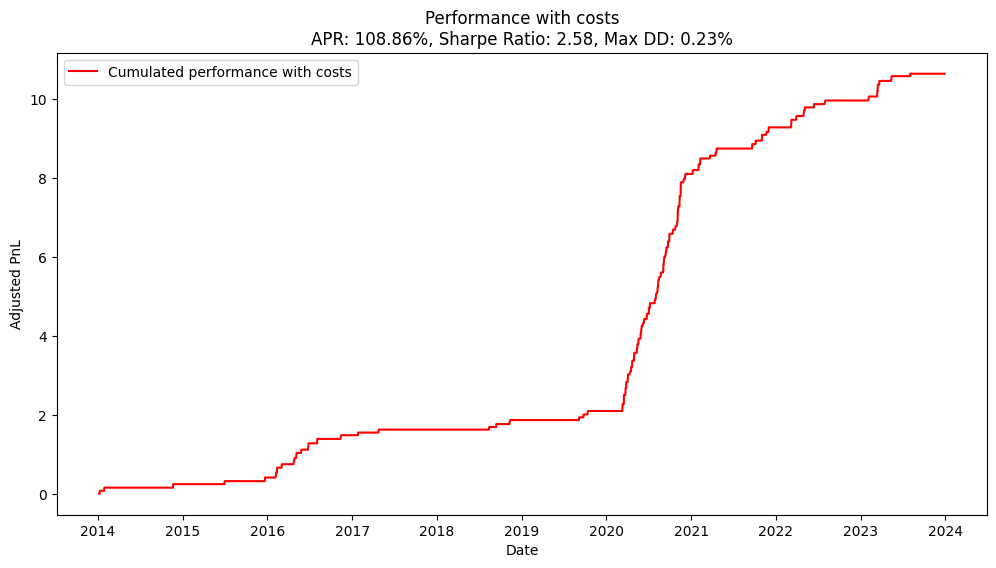

In [66]:
if most_cointegrated_pair is not None:
    pair_name = most_cointegrated_pair["Pair"]

    if pair_name in spread_df.columns:
        spread = spread_df[pair_name].dropna()  # Extract the spread without NaN

       # Computation of logarithmic returns
        spread = np.log(spread / spread.shift(1)).dropna()

        # Compute the mean and standard deviation of the spread
        mean_spread = spread.mean()
        std_spread = spread.std()

        # threshold setting
        alpha_L = mean_spread - 2*std_spread
        alpha_S = mean_spread + 2*std_spread
        alpha_exit = mean_spread

        # Initializing variables for the strategy
        position = 0  # 0 = no position, 1 = long, -1 = short
        pnl_with_costs_strat = 0  # Cumulated Profit/loss
        pnl_history_with_costs = []  # PnL History
        signals = []  # Signal History
        total_transaction_costs = 0  #Cumulative transaction costs
        short_costs = 0  # Borrowing costs for short positions

        # Set daily borrowing rate for short
        daily_borrowing_rate = 0.002

        # Day by day simulation
        for i in range(len(spread)):
            current_spread = spread.iloc[i]

            if position == 0:  # No position
                if current_spread < alpha_L:
                    position = 1  # Take a long position
                    entry_price = current_spread
                    # entry cost computation
                    transaction_cost = 0.0008 * abs(entry_price) + 0.002 * abs(entry_price)
                    total_transaction_costs += transaction_cost
                    signals.append((spread.index[i], "Long"))
                elif current_spread > alpha_S:
                    position = -1  # take a short position
                    entry_price = current_spread
                    # entry cost computation
                    transaction_cost = 0.0008 * abs(entry_price) + 0.002 * abs(entry_price)
                    total_transaction_costs += transaction_cost
                    signals.append((spread.index[i], "Short"))
            elif position == 1:  # long position
                if current_spread >= alpha_exit:
                    pnl_with_costs_strat += current_spread - entry_price  # computing PnL
                    # exit cost computation
                    transaction_cost = 0.0008 * abs(current_spread) + 0.002 * abs(current_spread)
                    total_transaction_costs += transaction_cost
                    position = 0  # exit the position
                    signals.append((spread.index[i], "Exit Long"))
            elif position == -1:  # short position
                # Add daily borrowing costs to maintain the position
                short_costs += abs(entry_price) * daily_borrowing_rate

                if current_spread <= alpha_exit:
                    pnl_with_costs_strat += entry_price - current_spread  # PnL computation
                    # exit cost computation
                    transaction_cost = 0.0008 * abs(current_spread) + 0.002 * abs(current_spread)
                    total_transaction_costs += transaction_cost
                    position = 0  # exit position
                    signals.append((spread.index[i], "Exit Short"))

            # Record cumulative PnL by adjusting costs
            pnl_history_with_costs.append(pnl_with_costs_strat - total_transaction_costs - short_costs)

        # strategy results
        print(f"Final Pnl after costs implementation : {pnl_with_costs_strat - total_transaction_costs - short_costs}")
        print(f"Total cost of transactions : {total_transaction_costs}")
        print(f"Total cost of borrowing : {short_costs}")

        # Recalculation of metrics after costs

        # daily returns
        daily_returns_with_costs = np.diff(pnl_history_with_costs) / 1  # divided by an initial investment

        # APR
        apr_with_costs = ((np.sum(daily_returns_with_costs)) * (252 / len(spread)))*100

        # Sharpe Ratio
        sharpe_ratio_with_costs = (np.mean(daily_returns_with_costs) - 0.03 / 100) / np.std(daily_returns_with_costs) * np.sqrt(252)

        # Maximum Drawdown
        pnl_array = np.array(pnl_history_with_costs)
        cumulative_max = np.maximum.accumulate(pnl_array)
        cumulative_max[cumulative_max == 0] = np.nan  # avoid dividing by zero
        drawdowns = (cumulative_max - pnl_array) / cumulative_max
        max_drawdown_with_costs = np.nanmax(drawdowns)

        print(f"APR : {apr_with_costs:.2f}%")
        print(f"Sharpe Ratio : {sharpe_ratio_with_costs:.2f}")
        print(f"Maximum Drawdown : {max_drawdown_with_costs:.2%}")

        #  graphiques
        plt.figure(figsize=(12, 6))
        plt.plot(spread.index, pnl_history_with_costs, label="Cumulated performance with costs", color="red")
        plt.title(f"Performance with costs\nAPR: {apr_with_costs:.2f}%, Sharpe Ratio: {sharpe_ratio_with_costs:.2f}, Max DD: {max_drawdown_with_costs:.2%}")
        plt.xlabel("Date")
        plt.ylabel("Adjusted PnL")
        plt.legend()
        plt.show()




---



# **ML implementation on our Pair Trading Strategy**

##Predicting Spreads Using Macroeconomic Data and Artificial Neural Networks (ANN)

# **Ressources**
####We applied an approach to analyze and trade on spreads derived from cointegrated asset pairs. By combining macroeconomic data from ECB with normalized spreads, the model predicts the spread using a deep learning Artificial Neural Network (ANN). Artificial Neural Networks are particularly well-suited for financial time series forecasting due to their ability to model complex, non-linear relationships inherent in financial data. Their flexibility allows them to capture intricate patterns that traditional linear models might overlook. This capability is especially beneficial in financial markets, where asset prices are influenced by a multitude of interrelated factors.

####The Artificial Neural Network (ANN) implemented in this model is designed for regression tasks to predict normalized spreads. It consists of an input layer determined by the number of macroeconomic features, two hidden layers with 128 and 64 neurons respectively (both using the ReLU activation function), and an output layer with a single neuron and a linear activation function for continuous value predictions. The model uses the Adam optimizer, known for its efficiency in handling noisy gradients and adaptive learning rates, combined with the Mean Squared Error (MSE) loss function to minimize prediction errors. Training parameters include 50 epochs, a batch size of 32, and a validation split of 20% to monitor performance. The Mean Absolute Error (MAE) is used as an evaluation metric to quantify the model’s predictive accuracy. This architecture is designed to balance complexity and computational efficiency, making it well-suited for capturing non-linear relationships in the macroeconomic data while ensuring robust regression outputs.

###**Data Normalization:**
####Macroeconomic data is scaled using *MinMaxScaler*  to fit values between 0 and 1.Spreads are normalized to zero mean and unit variance for compatibility with the ANN model.

###**Network Structure:**
####**Input Layer:** The first layer takes the macroeconomic data as input (the number of neurons corresponds to the number of macro variables).
####**Hidden Layers:** The first hidden layer has 1500 neurons, allowing the model to learn complex representations of the data. The second hidden layer has 1000 neurons, reducing the dimensionality to simplify computations without losing too much information.
####**Output Layer:** The final layer has 1 neuron, as we are predicting a single value: the spread.


In [67]:
#preprocessing of the ECB's datas to adjust the Dates
combined_df_ecb['Date'] = pd.to_datetime(combined_df_ecb['Date'])
combined_df_ecb.set_index('Date', inplace=True)

Most cointegrated pair is: BBVA.MC_ISP.MI
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 1.1721 - mae: 0.7623 - val_loss: 1.4317 - val_mae: 0.8265
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.0164 - mae: 0.6957 - val_loss: 1.2283 - val_mae: 0.6655
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.9874 - mae: 0.7547 - val_loss: 1.1976 - val_mae: 0.6296
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.1803 - mae: 0.7810 - val_loss: 1.2665 - val_mae: 0.6920
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.0744 - mae: 0.7222 - val_loss: 1.3763 - val_mae: 0.7829
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.8124 - mae: 0.6568 - val_loss: 1.4763 - val_mae: 0.8676
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.0684 - mae: 0.7220 - val_loss: 1.5274 - val_mae: 0.9061
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.9096 - mae: 0.7126 - val_loss: 1.5020 - val_mae: 0.8855
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.8529 - mae: 0.6845 - val_loss: 

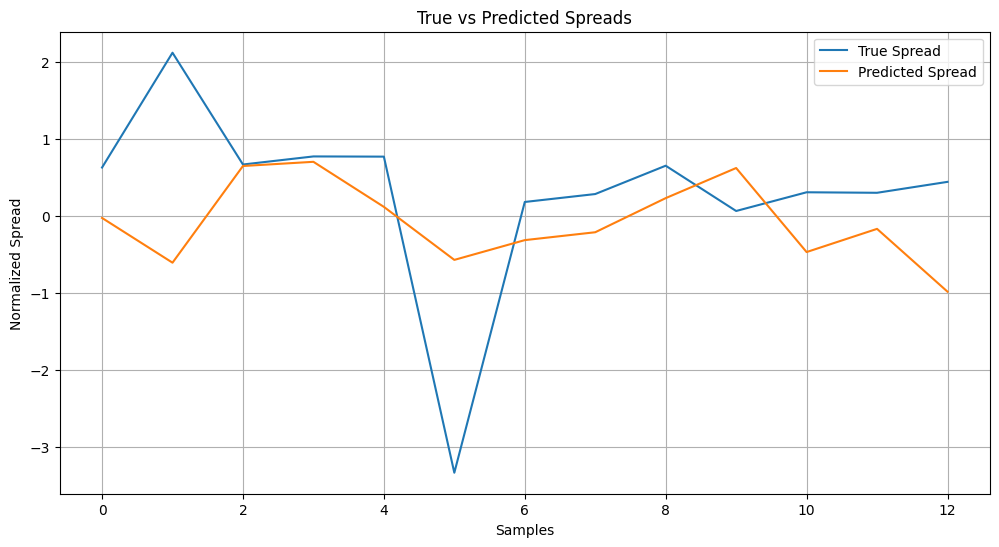

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
alpha: -1.8323588334023952
Final Profit/loss : 19.765192819926
Total costs : 0.0632690999507904


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


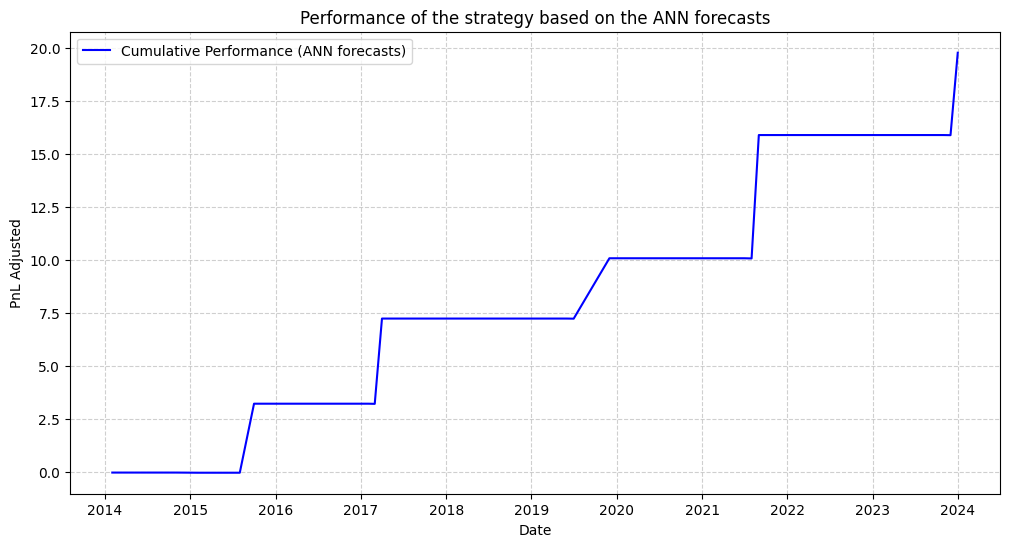

PnL after costs : 19.765192819926
Total transaction costs : 0.0632690999507904
Total short costs : 0.023551429656290347
APR : 202.36%
Sharpe Ratio : 3.53
Maximum Drawdown : 0.22%


In [68]:
# We use combined_df_ecb for the ECB datas
macro_data = combined_df_ecb.copy()

# time period starting in 2014
start_date = "2014-01-01"
end_date = "2024-01-01"
macro_data = macro_data.loc[start_date:end_date].dropna()

if not cointegrated_pairs.empty:
    # finding the most cointegrated pair
    most_cointegrated_pair = cointegrated_pairs.loc[cointegrated_pairs["p-value"].idxmin()]
    pair_name = most_cointegrated_pair["Pair"]
    print("Most cointegrated pair is:", pair_name)

    # using this pair to compute the spread
    stock_1, stock_2 = pair_name.split('_')
    spread = spreads[pair_name].loc[start_date:end_date].dropna()
    spread.index = spread.index.tz_localize(None)  # deleting time zone

    # Normalization of the macroeconomic datas
    scaler = MinMaxScaler()
    macro_data_normalized = pd.DataFrame(scaler.fit_transform(macro_data), columns=macro_data.columns, index=macro_data.index)

    # Spread normalization
    spread_normalized = (spread - spread.mean()) / spread.std()

    # merging macro datas with the spreads
    combined_data = pd.concat([macro_data_normalized, spread_normalized], axis=1).dropna()
    X = combined_data.iloc[:, :-1].values
    y = combined_data.iloc[:, -1].values  # Normalized Spread

    # split of the datas (training/test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Building the ANN model
    model = Sequential([
        Dense(1500, input_dim=X_train.shape[1], activation='relu'),
        Dense(1000, activation='relu'),
        Dense(1, activation='linear')  # 1 output for the spread
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # training of the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # spread forecasting
    predicted_spreads = model.predict(X_test)

    # model evaluation
    loss, mae = model.evaluate(X_test, y_test, verbose=0)

    # Results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='True Spread')
    plt.plot(predicted_spreads, label='Predicted Spread')
    plt.legend()
    plt.title("True vs Predicted Spreads")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Spread")
    plt.grid()
    plt.show()

else:
    print("No cointegrated pair found.")

# forecasting the spread for all dats
spread_pred = model.predict(macro_data_normalized.values)
spread_pred_series = pd.Series(spread_pred.flatten(), index=macro_data_normalized.index)

# Computing of the logarithmic return of the predicted spread
spread = spread_pred_series
spread = np.log(spread / spread.shift(1)).dropna()

# Strategy settings
mean_spread = spread.mean()
std_spread = spread.std()
alpha_L = mean_spread - 2*std_spread  # threshold to be long
alpha_S = mean_spread + 2*std_spread  # threshold to be short
alpha_exit = mean_spread            # threshold to close the position
print ("alpha:",alpha_L)


# strategy implementing
position = 0
pnl_ann = 0
pnl_history_ann = []
signals = []
total_transaction_costs = 0

# Set daily borrowing rate for short
daily_borrowing_rate = 0.002

for i in range(len(spread)):
    current_spread = spread.iloc[i]

    if position == 0:  # No position
        if current_spread < alpha_L:
            position = 1
            entry_price = current_spread
            transaction_cost = 0.0008 * abs(entry_price) + 0.002 * abs(entry_price)
            total_transaction_costs += transaction_cost
            signals.append((spread.index[i], "Long"))
        elif current_spread > alpha_S:
            position = -1
            entry_price = current_spread
            transaction_cost = 0.0008 * abs(entry_price) + 0.002 * abs(entry_price)
            total_transaction_costs += transaction_cost
            signals.append((spread.index[i], "Short"))
    elif position == 1:  # Long position
        if current_spread >= alpha_exit:
            pnl_ann += current_spread - entry_price
            transaction_cost = 0.0008 * abs(current_spread) + 0.002 * abs(current_spread)
            total_transaction_costs += transaction_cost
            position = 0
            signals.append((spread.index[i], "Exit Long"))
    elif position == -1:  # Short position
        if current_spread <= alpha_exit:
            pnl_ann += entry_price - current_spread
            # Add daily borrowing costs to maintain the position
            short_costs += abs(entry_price) * daily_borrowing_rate
            total_transaction_costs += transaction_cost
            position = 0
            signals.append((spread.index[i], "Exit Short"))

    pnl_history_ann.append(pnl_ann - total_transaction_costs - short_costs)

# Results
print(f"Final Profit/loss : {pnl_ann - total_transaction_costs - short_costs}")
print(f"Total costs : {total_transaction_costs}")

# Visualization of the strategy performances
plt.figure(figsize=(12, 6))
plt.plot(spread.index, pnl_history_ann, label="Cumulative Performance (ANN forecasts)", color="blue")
plt.title("Performance of the strategy based on the ANN forecasts")
plt.xlabel("Date")
plt.ylabel("PnL Adjusted")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# strategy results
print(f"PnL after costs : {pnl_ann - total_transaction_costs - short_costs}")
print(f"Total transaction costs : {total_transaction_costs}")
print(f"Total short costs : {short_costs}")

# Recalculation of metrics after costs

# daily returns
daily_returns_ann = np.diff(pnl_history_ann) / 1  # divided by an initial investment

# APR
apr_ann = ((np.sum(daily_returns_ann)) * (252 / 2463))*100

# Sharpe Ratio
sharpe_ratio_ann = (np.mean(daily_returns_ann) - 0.03 / 100) / np.std(daily_returns_ann) * np.sqrt(252)

# Maximum Drawdown
pnl_array = np.array(pnl_history_ann)
cumulative_max = np.maximum.accumulate(pnl_array)
cumulative_max[cumulative_max == 0] = np.nan  # avoid dividing by zero
drawdowns = (cumulative_max - pnl_array) / cumulative_max
max_drawdown_ann = np.nanmax(drawdowns)

print(f"APR : {apr_ann:.2f}%")
print(f"Sharpe Ratio : {sharpe_ratio_ann:.2f}")
print(f"Maximum Drawdown : {max_drawdown_ann:.2%}")


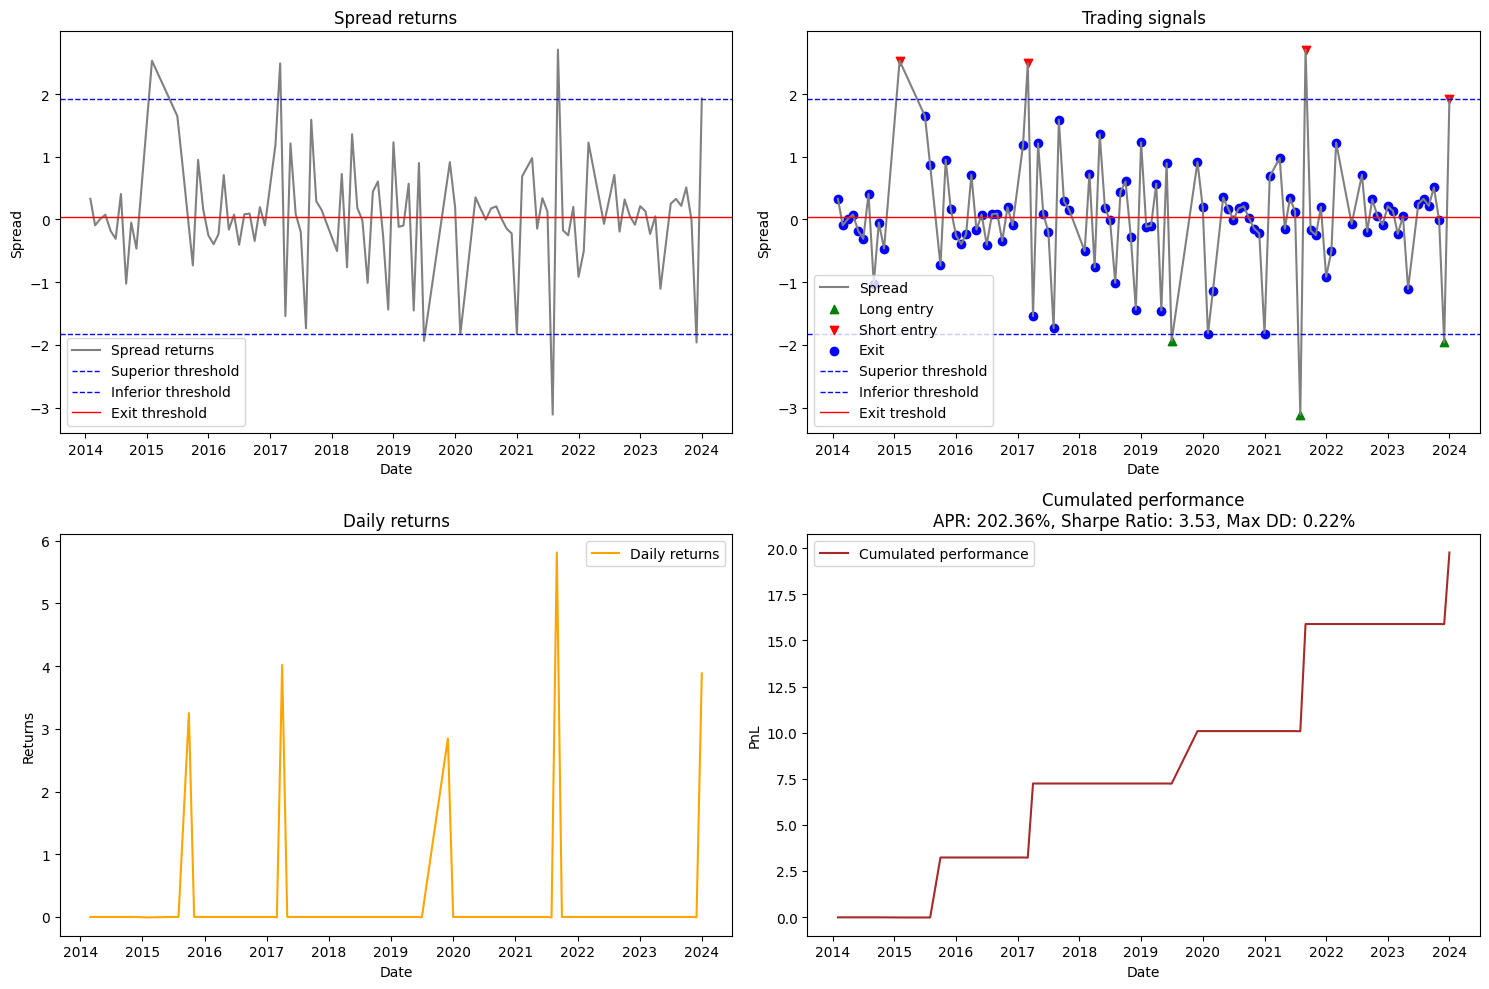

In [69]:
#Visualizations

upper_threshold = mean_spread - 2*std_spread
lower_threshold = mean_spread + 2*std_spread
exit_threshold = mean_spread

# Creation of the Figure with Multiple Subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Chart 1: Spread with Thresholds and Signals
axs[0, 0].plot(spread.index, spread, label="Spread returns", color="gray")
axs[0, 0].axhline(upper_threshold, color="blue", linestyle="--", linewidth=1, label="Superior threshold")
axs[0, 0].axhline(lower_threshold, color="blue", linestyle="--", linewidth=1, label="Inferior threshold")
axs[0, 0].axhline(exit_threshold, color="red", linestyle="-", linewidth=1, label="Exit threshold")
axs[0, 0].legend()
axs[0, 0].set_title("Spread returns")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Spread")

# Chart 2: Trading signals
long_signals = spread < upper_threshold
short_signals = spread > lower_threshold
exit_signals = (spread >= upper_threshold) & (spread <= lower_threshold)

axs[0, 1].plot(spread.index, spread, label="Spread", color="gray")
axs[0, 1].scatter(spread.index[long_signals], spread[long_signals], color="green", label="Long entry", marker="^")
axs[0, 1].scatter(spread.index[short_signals], spread[short_signals], color="red", label="Short entry", marker="v")
axs[0, 1].scatter(spread.index[exit_signals], spread[exit_signals], color="blue", label="Exit", marker="o")
axs[0, 1].axhline(upper_threshold, color="blue", linestyle="--", linewidth=1, label="Superior threshold")
axs[0, 1].axhline(lower_threshold, color="blue", linestyle="--", linewidth=1, label="Inferior threshold")
axs[0, 1].axhline(mean_spread, color="red", linestyle="-", linewidth=1, label="Exit treshold")
axs[0, 1].legend()
axs[0, 1].set_title("Trading signals")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Spread")

# Chart 3: Daily Returns
axs[1, 0].plot(spread.index[1:], daily_returns_ann, label="Daily returns", color="orange")
axs[1, 0].legend()
axs[1, 0].set_title("Daily returns")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Returns")

# Chart 4: Cumulative PnL
axs[1, 1].plot(spread.index, pnl_history_ann, label="Cumulated performance", color="brown")
axs[1, 1].legend()
axs[1, 1].set_title(f"Cumulated performance\nAPR: {apr_ann:.2f}%, Sharpe Ratio: {sharpe_ratio_ann:.2f}, Max DD: {max_drawdown_ann:.2%}")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("PnL")

plt.tight_layout()
plt.show()


## Introducing ML based Dynamic thresholds for trade execution
Instead of relying on static thresholds `alpha_L` and `alpha_S`, we integrate a Random Forest model to predict these thresholds dynamically based on macroeconomic data and the predicted spread from the ANN. This enhancement allows the thresholds to adapt to changing market conditions, making the strategy more flexible and responsive. By dynamically adjusting the entry and exit points, the model is expected to identify more trading opportunities and execute a greater number of trades.

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.1780 - mae: 0.7424 - val_loss: 0.9554 - val_mae: 0.7621
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.0038 - mae: 0.6881 - val_loss: 1.0267 - val_mae: 0.7989
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0571 - mae: 0.6861 - val_loss: 1.0125 - val_mae: 0.7594
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0998 - mae: 0.7058 - val_loss: 1.0199 - val_mae: 0.7469
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.9243 - mae: 0.6418 - val_loss: 0.9933 - val_mae: 0.7489
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.9190 - mae: 0.6326 - val_loss: 0.9794 - val_mae: 0.7656
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0253 - mae: 0.6682 - val_loss: 0.9906 - val_mae: 0.7755
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9006 - mae: 0.6320 - val_loss: 0.9983 - val_mae: 0.7772
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.9153 - mae: 0.6203 - val_loss: 

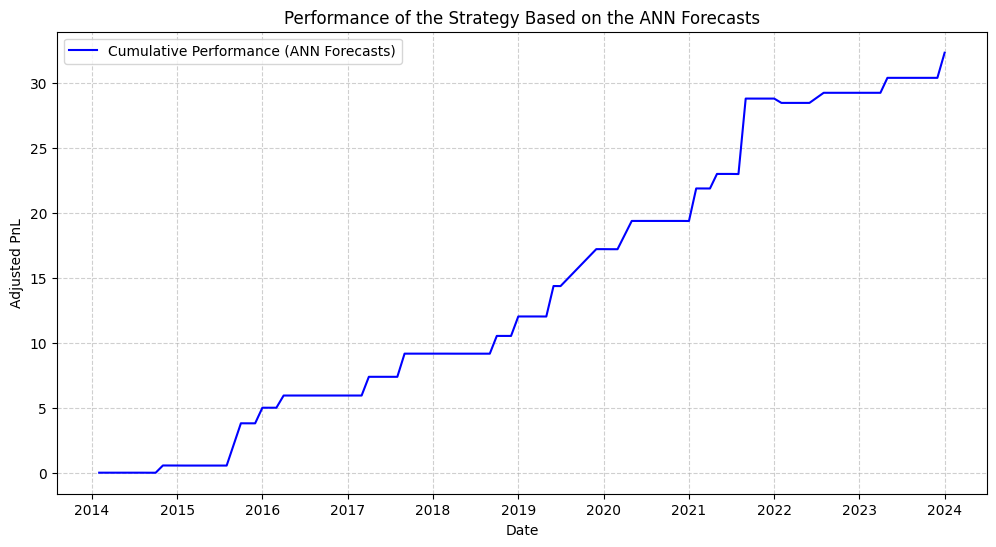

Final Profit/Loss After Costs: 32.34821060817129
Total Transaction Costs: 0.09683760556392373
Total Short Costs: 0.009205400213599205
APR: 330.97%
Sharpe Ratio: 5.86
Maximum Drawdown: 1.28%


In [70]:
# Data Normalization
scaler = MinMaxScaler()
macro_data_normalized = pd.DataFrame(scaler.fit_transform(macro_data), columns=macro_data.columns, index=macro_data.index)

# Spread Normalization
spread_normalized = (spread - spread.mean()) / spread.std()

# Merge Macro Data with Spreads
combined_data = pd.concat([macro_data_normalized, spread_normalized], axis=1).dropna()
X = combined_data.iloc[:, :-1].values
y = combined_data.iloc[:, -1].values  # Normalized spread

# Split Data into Training and Testing Sets for ANN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build ANN Model to Predict Spread
model_spread = Sequential([
    Dense(1500, input_dim=X_train.shape[1], activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1, activation='linear')  # One output: the spread
])

model_spread.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the Model to Predict Spread
history_spread = model_spread.fit(X_train, y_train,
                                  epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Spread Prediction
spread_pred = model_spread.predict(macro_data_normalized.values)
spread_pred_series = pd.Series(spread_pred.flatten(), index=macro_data_normalized.index)

# Adjust Target Size to Match Features for Thresholds
features_for_thresholds = macro_data_normalized.copy()
features_for_thresholds['predicted_spread'] = spread_pred_series

valid_indices = features_for_thresholds.index.intersection(combined_data.index)
features_for_thresholds = features_for_thresholds.loc[valid_indices]
y_adjusted = y[:len(valid_indices)]

# Create Data for Dynamic Threshold Prediction
y_thresholds = np.column_stack([
    y_adjusted - 0.5 * np.std(y_adjusted),  # alpha_L
    y_adjusted + 0.5 * np.std(y_adjusted)   # alpha_S
])

# Split Data into Training and Testing Sets for Thresholds
X_thresholds = features_for_thresholds.values
X_train_th, X_test_th, y_train_th, y_test_th = train_test_split(X_thresholds, y_thresholds, test_size=0.2, random_state=42)

# Use RandomForest Model to Predict Dynamic Thresholds
model_thresholds = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
model_thresholds.fit(X_train_th, y_train_th)

# Predict Dynamic Thresholds
predicted_thresholds = model_thresholds.predict(features_for_thresholds.values)

# Extract Predicted alpha_L and alpha_S
alpha_L_series = pd.Series(predicted_thresholds[:, 0], index=features_for_thresholds.index)
alpha_S_series = pd.Series(predicted_thresholds[:, 1], index=features_for_thresholds.index)
alpha_L_series *= 0.8  # Make the lower threshold more permissive
alpha_S_series *= 1.3  # Make the upper threshold more permissive

# Implement Strategy with Predictions
position = 0
pnl_annv2 = 0
pnl_history_annv2 = []
signals = []
total_transaction_costsv2 = 0
short_costsv2 = 0

daily_borrowing_rate = 0.002  # Daily borrowing rate for short positions

# Synchronize Indices
common_indices = spread.index.intersection(alpha_L_series.index).intersection(alpha_S_series.index)
spread = spread.loc[common_indices]
alpha_L_series = alpha_L_series.loc[common_indices]
alpha_S_series = alpha_S_series.loc[common_indices]

# Verification
assert len(spread) == len(alpha_L_series) == len(alpha_S_series)

for i in range(len(spread)):
    current_spread = spread.iloc[i]
    alpha_L = alpha_L_series.iloc[i]
    alpha_S = alpha_S_series.iloc[i]
    alpha_exit = (alpha_L + alpha_S) / 2  # Dynamic exit threshold

    if position == 0:  # No position
        if current_spread < alpha_L:
            position = 1
            entry_price = current_spread
            transaction_cost = 0.0008 * abs(entry_price) + 0.002 * abs(entry_price)
            total_transaction_costsv2 += transaction_cost
            signals.append((spread.index[i], "Long"))
        elif current_spread > alpha_S:
            position = -1
            entry_price = current_spread
            transaction_cost = 0.0008 * abs(entry_price) + 0.002 * abs(entry_price)
            total_transaction_costsv2 += transaction_cost
            signals.append((spread.index[i], "Short"))
    elif position == 1:  # Long Position
        if current_spread >= alpha_exit:
            pnl_annv2 += current_spread - entry_price
            transaction_cost = 0.0008 * abs(current_spread) + 0.002 * abs(current_spread)
            total_transaction_costsv2 += transaction_cost
            position = 0
            signals.append((spread.index[i], "Exit Long"))
    elif position == -1:  # Short Position
        if current_spread <= alpha_exit:
            pnl_annv2 += entry_price - current_spread
            short_costsv2 += abs(entry_price) * daily_borrowing_rate
            transaction_cost = 0.0008 * abs(current_spread) + 0.002 * abs(current_spread)
            total_transaction_costsv2 += transaction_cost
            position = 0
            signals.append((spread.index[i], "Exit Short"))

    pnl_history_annv2.append(pnl_annv2 - total_transaction_costsv2 - short_costsv2)

# Results

# Visualization of Strategy Performance
plt.figure(figsize=(12, 6))
plt.plot(spread.index, pnl_history_annv2, label="Cumulative Performance (ANN Forecasts)", color="blue")
plt.title("Performance of the Strategy Based on the ANN Forecasts")
plt.xlabel("Date")
plt.ylabel("Adjusted PnL")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# Strategy Results
print(f"Final Profit/Loss After Costs: {pnl_annv2 - total_transaction_costsv2 - short_costsv2}")
print(f"Total Transaction Costs: {total_transaction_costsv2}")
print(f"Total Short Costs: {short_costsv2}")

# Recalculation of Metrics After Costs

# Daily Returns
daily_returns_annv2 = np.diff(pnl_history_annv2) / 1  # Divided by initial investment

# APR
apr_annv2 = ((np.sum(daily_returns_annv2)) * (252 / 2463))*100

# Sharpe Ratio
sharpe_ratio_annv2 = (np.mean(daily_returns_annv2) - 0.03 / 100) / np.std(daily_returns_annv2) * np.sqrt(252)

# Maximum Drawdown
pnl_array = np.array(pnl_history_annv2)
cumulative_max = np.maximum.accumulate(pnl_array)
cumulative_max[cumulative_max == 0] = np.nan  # Avoid division by zero
drawdowns = (cumulative_max - pnl_array) / cumulative_max
max_drawdown_annv2 = np.nanmax(drawdowns)

print(f"APR: {apr_annv2:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio_annv2:.2f}")
print(f"Maximum Drawdown: {max_drawdown_annv2:.2%}")


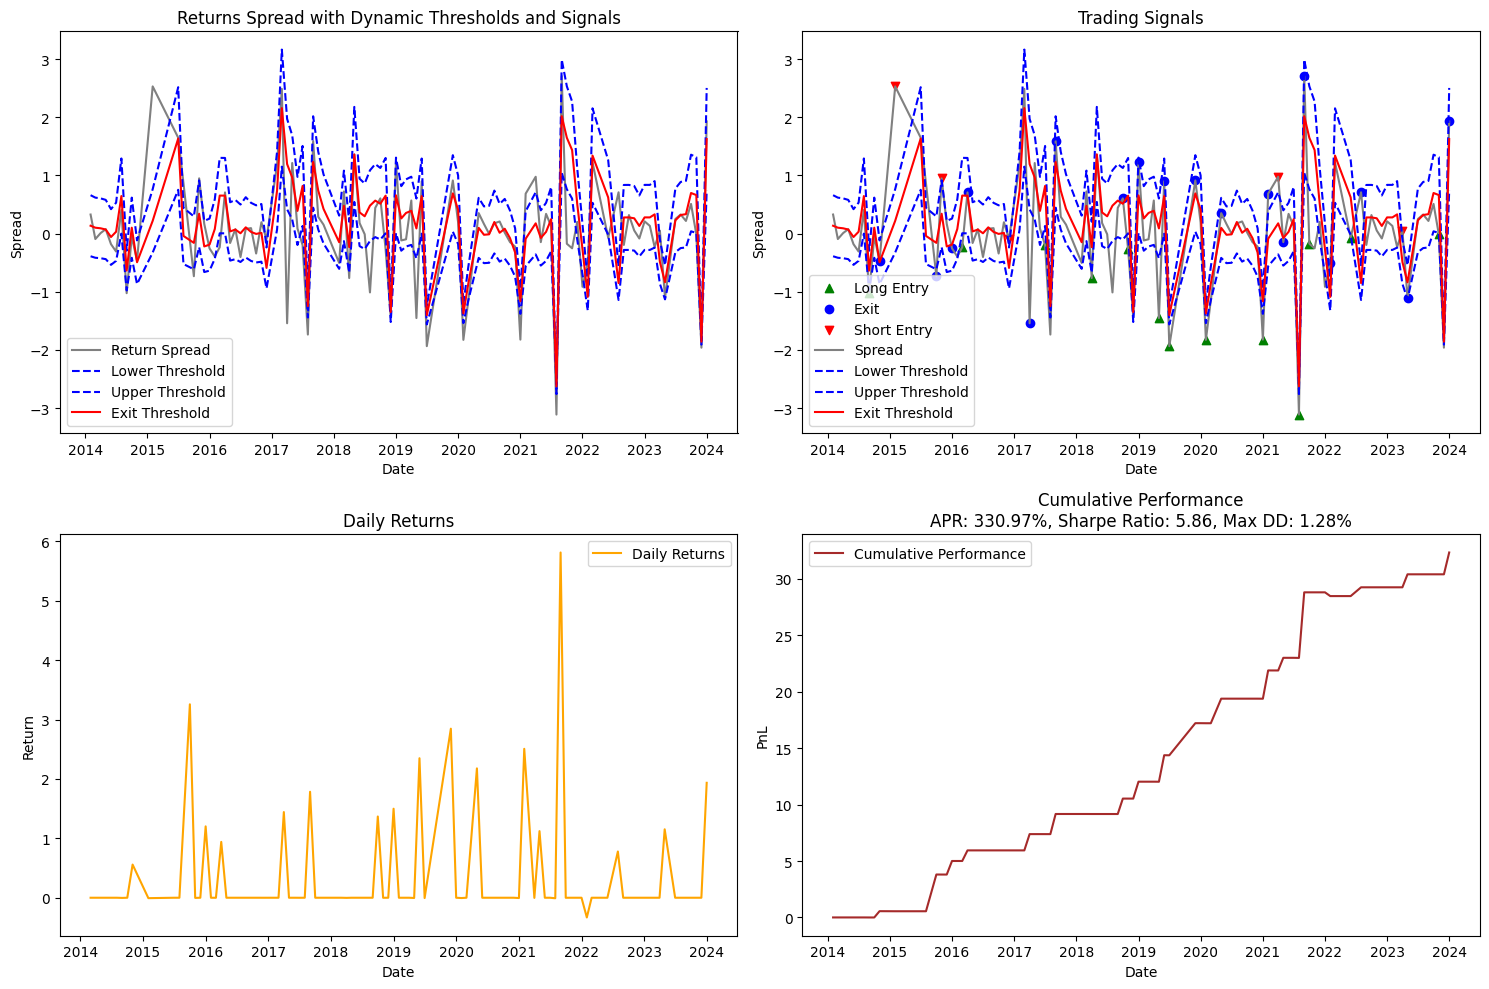

In [71]:
# Visualization of the Spread, Dynamic Thresholds, and Performance
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Chart 1: Spread with Thresholds and Signals
axs[0, 0].plot(spread.index, spread, label="Return Spread", color="gray")
axs[0, 0].plot(alpha_L_series.index, alpha_L_series, color="blue", linestyle="--", label="Lower Threshold")
axs[0, 0].plot(alpha_S_series.index, alpha_S_series, color="blue", linestyle="--", label="Upper Threshold")
axs[0, 0].plot(spread.index, (alpha_L_series + alpha_S_series) / 2, color="red", linestyle="-", label="Exit Threshold")
axs[0, 0].legend()
axs[0, 0].set_title("Returns Spread with Dynamic Thresholds and Signals")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Spread")

# Chart 2: Trading Signals
unique_labels = set()
for date, signal in signals:
    if signal == "Long":
        label = "Long Entry" if "Long Entry" not in unique_labels else ""
        unique_labels.add("Long Entry")
        axs[0, 1].scatter(date, spread.loc[date], color="green", marker="^", label=label)
    elif signal == "Short":
        label = "Short Entry" if "Short Entry" not in unique_labels else ""
        unique_labels.add("Short Entry")
        axs[0, 1].scatter(date, spread.loc[date], color="red", marker="v", label=label)
    elif signal.startswith("Exit"):
        label = "Exit" if "Exit" not in unique_labels else ""
        unique_labels.add("Exit")
        axs[0, 1].scatter(date, spread.loc[date], color="blue", marker="o", label=label)

axs[0, 1].plot(spread.index, spread, label="Spread", color="gray")
axs[0, 1].plot(alpha_L_series.index, alpha_L_series, color="blue", linestyle="--", label="Lower Threshold")
axs[0, 1].plot(alpha_S_series.index, alpha_S_series, color="blue", linestyle="--", label="Upper Threshold")
axs[0, 1].plot(spread.index, (alpha_L_series + alpha_S_series) / 2, color="red", linestyle="-", label="Exit Threshold")
axs[0, 1].legend()
axs[0, 1].set_title("Trading Signals")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Spread")

# Chart 3: Daily Returns
axs[1, 0].plot(spread.index[1:], daily_returns_annv2, label="Daily Returns", color="orange")
axs[1, 0].legend()
axs[1, 0].set_title("Daily Returns")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Return")

# Chart 4: Cumulative PnL
axs[1, 1].plot(spread.index, pnl_history_annv2, label="Cumulative Performance", color="brown")
axs[1, 1].legend()
axs[1, 1].set_title(f"Cumulative Performance\nAPR: {apr_annv2:.2f}%, Sharpe Ratio: {sharpe_ratio_annv2:.2f}, Max DD: {max_drawdown_annv2:.2%}")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("PnL")

plt.tight_layout()
plt.show()


#**4- Empirical resuts: baseline and robustness**







#### 1. **Summary of Results**

1. ## Simple ANN model

We can see that **the ANN capture the general trend of the true spreads**, but the deviations suggest that the model **lacks precision in capturing finer movements**. Especially with some outlyers caused by external market events. Additionally, the predicted spreads tend to be consistently lower over time, leading to fewer trades being executed and thus missed trading opportunities. This limitation highlights the impact of conservative spread predictions on the overall trading strategy. By increasing the number of hidden layers in the neural network, the Mean Absolute Error (MAE) has reduced,  demonstrating an improvement in the model.
Looking at the cumulative performance of the trading strategy only based on ANN predictions demonstrates steady gains over time, accounting for transaction costs. However, the ANN model tends to underestimate the magnitude of the spread, which **narrows drasticly the range of trading opportunities**. This limitation partly explains why the overall performance exceed the results achieved without using the ANN model. In addition, the very low number of trades amplifies volatility, as each trade carries a disproportionate weight on the cumulative performance. This is further aggravated if the model struggles to accurately predict spread movements using imprecise monthly data, leading to missed signals and conservative entries. To mitigate these risks, using higher-frequency data (daily instead of monthly) could allow the model to identify and exploit spread deviations more effectively, increasing trade frequency and stabilizing returns.


2. ## Model Improvement: Integration of Random Forest with ANN

The improvement made to the model involves augmenting the ANN with a Random Forest to enhance the decision-making process for dynamic trading thresholds. While the ANN is responsible for predicting the spread based on macroeconomic data and other inputs, the Random Forest model was added to dynamically predict the trading thresholds `alpha_L` and `alpha_S`, which define the entry and exit points for trades.
By incorporating the Random Forest, the model use its ability to handle non-linear relationships and feature importance, ensuring that the thresholds adapt more effectively to changing market conditions. This dual-model approach allows the strategy to be more flexible and responsive, ultimately increasing the number of trades executed while maintaining a structured risk management framework. The use of dynamic thresholds significantly increases the number of trades performed, as the model becomes more sensitive to market opportunities.



#**5- Conclusion**

In [72]:

# Création des données
data = {
    "Parameters": ["Final Pnl", "APR (%)", "Sharpe Ratio", "Maximum Drawdown (%)"],
    "Standard Strategy": [pnl, apr, sharpe_ratio, max_drawdown],
    "Standard strategy with costs implementation": [pnl_with_costs_strat - total_transaction_costs - short_costs, apr_with_costs, sharpe_ratio_with_costs, max_drawdown_with_costs],
    "ML-based strategy with ANN implementation(%)": [pnl_ann - total_transaction_costs - short_costs, apr_ann, sharpe_ratio_ann, max_drawdown_ann],
    "ML-based strategy with ANN implementation and dynamic tresholds using Random Forest(%)": [pnl_annv2 - total_transaction_costsv2 - short_costsv2, apr_annv2, sharpe_ratio_annv2, max_drawdown_annv2],
}

# Création du DataFrame
df = pd.DataFrame(data)

# Application des styles avec Pandas
results_df = (
    df.style
    .set_caption("Performances obtained with different strategies used (for 1€ invested).")
    .set_table_styles(
        [
            {"selector": "caption", "props": [("font-size", "14px"), ("font-weight", "bold"), ("text-align", "center")]},
            {"selector": "th", "props": [("background-color", "#f2f2f2"), ("font-weight", "bold"), ("text-align", "center")]},
            {"selector": "td", "props": [("text-align", "center"), ("border", "1px solid #ddd")]},
        ]))

results_df


,Parameters,Standard Strategy,Standard strategy with costs implementation,ML-based strategy with ANN implementation(%),ML-based strategy with ANN implementation and dynamic tresholds using Random Forest(%)
0,Final Pnl,10.679050,10.592230,19.765193,32.348211
1,APR (%),109.306284,108.861904,202.364356,330.968294
2,Sharpe Ratio,2.590118,2.582837,3.528509,5.855698
3,Maximum Drawdown (%),0.000000,0.002340,0.002156,0.012755


The aim of our project is to compare the results between different strategies, as the performance of the strategies themselves appears somewhat unrealistic.

The comparison of strategies highlights several key insights regarding their performance. The standard strategy serves as a baseline, showing solid performance metrics. However, when transaction costs are introduced, there is a slight degradation in performance, which emphasizes the impact of trading costs on profitability and the overall efficiency of the strategy. This underlines the importance of incorporating cost considerations into any realistic trading strategy implementation.

When a machine learning-based approach utilizing artificial neural networks (ANN) is applied, the results show significant improvements across all key metrics. This demonstrates the ability of advanced models to better capture market dynamics and improve decision-making compared to traditional approaches. The performance is further enhanced when dynamic thresholds are introduced using a Random Forest model. This combination leverages the strengths of adaptive machine learning techniques, resulting in optimized profitability, improved risk-adjusted returns, and effective drawdown management. Moreover, the use of the Random Forest model results in a higher number of executed trades, further enriching the strategy. Overall, the progression of strategies clearly illustrates the added value of integrating machine learning and dynamic adjustments into trading strategies.

The article "**Pairs Trading and Outranking: The Multi-Step-Ahead Forecasting Case**" by Nicolas Huck and published in the European Journal of Operational Research. This article provides valuable insights that align with and extend the scope of our project. Huck demonstrates the effectiveness of Artificial Neural Networks (ANN) in forecasting spreads for pairs trading, showing their ability to capture the non-linearities inherent in financial data. This article directly supports the use of ANN in our project. Additionally, the article introduces multi-step-ahead forecasting, which allows for greater flexibility and trading opportunities. **While our project focuses on a single prediction horizon, adopting Huck's multi-step methodology could enhance the predictive power and adaptability of the trading system**. To adopt this strategy we need more granular datas which is not the case today. Finally, Huck highlights the importance of portfolio diversification and active position management, which could inspire further improvements to the risk management strategies in this project.
These limitations highlight potential avenues for future extensions. Huck's methodology thus serves as both a validation of the current approach and a guide for further developments.

#**6- Sources**

1. **Sarmento, S. M., & Horta, N. (2020).** Enhancing a pairs trading strategy with the application of machine learning. *Expert Systems with Applications*, 158, 113490.

2. **Bui, Q., & Ślepaczuk, R. (2022).** Applying Hurst exponent in pair trading strategies on Nasdaq 100 index. *Physica A: Statistical Mechanics and its Applications*, 592, 126784.

3. **Huck, N. (2010).** Pairs trading and outranking: The multi-step-ahead forecasting case. *European Journal of Operational Research*, 207(3), 1702-1716.
